# SML 301

## Session 7: Random Forests

* bias-variance trade-off
* bagging
* boosting

In [1]:
# install packages (if need be)
#%pip install ISLP
#%pip install palmerpenguins

In [62]:
# load libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import sklearn.tree as tree

from ISLP import load_data , confusion_table
from matplotlib.pyplot import subplots
from palmerpenguins import load_penguins
from sklearn.ensemble import (RandomForestRegressor as RF,
                              GradientBoostingRegressor as GBR)
from sklearn.model_selection import train_test_split
from sklearn.tree import (DecisionTreeClassifier as DTC, DecisionTreeRegressor as DTR, plot_tree)
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# load data
penguins = load_penguins()
wage_raw = load_data("Wage")

def f(x): 
    (x+1)*x*(x-2)

# Bias-Variance Tradeoff

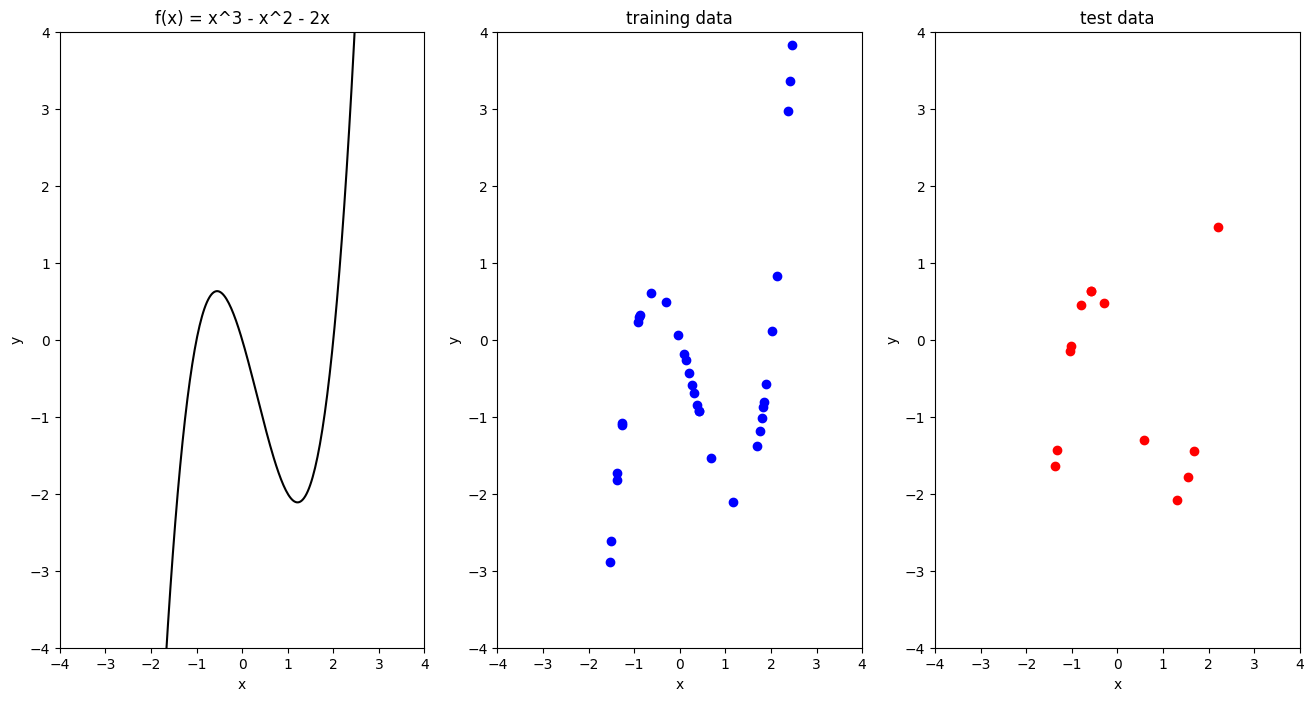

In [41]:
xseq = np.linspace(-4, 4, 301)
yseq = (xseq+1)*xseq*(xseq-2)

xseq_discrete = np.random.uniform(-4, 4, size = (1, 100))[0]
yseq_discrete = (xseq_discrete+1)*xseq_discrete*(xseq_discrete-2)
X_train, X_test, y_train, y_test = train_test_split(xseq_discrete , yseq_discrete, test_size = 0.3, random_state = 20250924)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 8))

ax1.plot(xseq, yseq, color = "black")
ax1.set_title("f(x) = x^3 - x^2 - 2x")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_xlim(-4,4)
ax1.set_ylim(-4,4)

ax2.scatter(X_train, y_train, color = "blue")
ax2.set_title("training data")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_xlim(-4,4)
ax2.set_ylim(-4,4)

ax3.scatter(X_test, y_test, color = "red")
ax3.set_title("test data")
ax3.set_xlabel("x")
ax3.set_ylabel("y")
ax3.set_xlim(-4,4)
ax3.set_ylim(-4,4)

plt.show()


In [45]:
X_train = X_train.reshape(70,1)
X_test = X_test.reshape(30,1)

tree_maker = DTR(criterion='friedman_mse', max_depth = 2, random_state = 301)
tree_model = tree_maker.fit(X_train, y_train)
R2_train = tree_model.score(X_train, y_train) #coefficient of determination
R2_test  = tree_model.score(X_test, y_test)
print(f'train R2: {R2_train:.4f}')
print(f'test R2 : {R2_test:.4f}')

train R2: 0.9340
test R2 : 0.7197


In [50]:
# initialize vectors (allocate space)
depth_vals = range(2,20) #sequence from 2 to 20 (but not including 20)
train_R2_vals = np.full(len(depth_vals), np.nan)
test_R2_vals = np.full(len(depth_vals), np.nan)

# make a tree for each candidate value for max_depth
for depth_val in range(2,20):
    tree_maker = DTR(criterion='friedman_mse', max_depth = depth_val, random_state = 301)
    tree_model = tree_maker.fit(X_train, y_train)
    index = depth_val - 2
    train_R2_vals[index] = tree_model.score(X_train, y_train) #coefficient of determination
    test_R2_vals[index]  = tree_model.score(X_test, y_test)

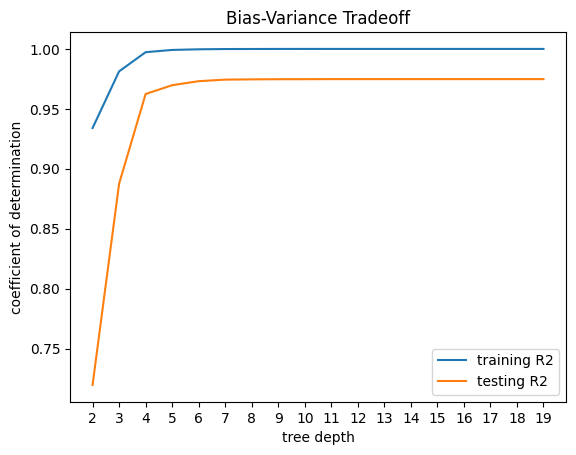

In [51]:
fig, ax = plt.subplots()
ax.plot(depth_vals, train_R2_vals, label = "training R2")
ax.plot(depth_vals, test_R2_vals, label = "testing R2")

ax.legend()
ax.set_title("Bias-Variance Tradeoff")
ax.set_xlabel("tree depth")
ax.set_ylabel("coefficient of determination")
ax.set_xticks(range(2,20))

plt.show()

Here, we explore the bias-variance tradeoff in the context of our decision tree regressor in order to choose an optimal tree depth to balance the training and testing errors.

In [3]:
df = penguins[['bill_length_mm', 'body_mass_g', 'flipper_length_mm', 'island', 'sex']] #load in needed columns
df = df.dropna() #then remove missing data
X = df[['body_mass_g', 'flipper_length_mm', 'island', 'sex']] #explanatory variables
y = df['bill_length_mm'] #target variable

X_num = X.select_dtypes(include = 'number')
X_cat = X.select_dtypes(include = 'object') #some recommend recasting as 'category'

X_cat_csr = OneHotEncoder().fit_transform(X_cat)
X_cat_hot = pd.DataFrame.sparse.from_spmatrix(X_cat_csr)
X_cat_hot.columns = OneHotEncoder().fit(X_cat).get_feature_names_out()

X_num_std = StandardScaler().fit_transform(X_num)
X_num_std = pd.DataFrame(X_num_std, columns = X_num.columns)

X = pd.concat([X_num_std, X_cat_hot], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 301)

In [4]:
tree_maker = DTR(criterion='friedman_mse', max_depth = 3, random_state = 301)
tree_model = tree_maker.fit(X_train, y_train)
R2_train = tree_model.score(X_train, y_train) #coefficient of determination
R2_test  = tree_model.score(X_test, y_test)
print(f'train R2: {R2_train:.4f}')
print(f'test R2 : {R2_test:.4f}')

train R2: 0.5869
test R2 : 0.4848


C:\Users\freex\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:919: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\freex\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:919: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\freex\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:919: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


In [14]:
# initialize vectors (allocate space)
depth_vals = range(2,20) #sequence from 2 to 20 (but not including 20)
train_R2_vals = np.full(len(depth_vals), np.nan)
test_R2_vals = np.full(len(depth_vals), np.nan)

# make a tree for each candidate value for max_depth
for depth_val in range(2,20):
    tree_maker = DTR(criterion='friedman_mse', max_depth = depth_val, random_state = 301)
    tree_model = tree_maker.fit(X_train, y_train)
    index = depth_val - 2
    train_R2_vals[index] = tree_model.score(X_train, y_train) #coefficient of determination
    test_R2_vals[index]  = tree_model.score(X_test, y_test)


C:\Users\freex\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:919: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\freex\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:919: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\freex\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:919: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\freex\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:919: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\freex\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:919

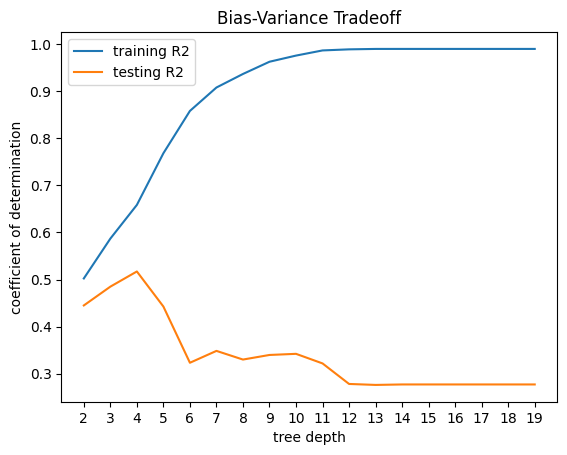

In [20]:
fig, ax = plt.subplots()
ax.plot(depth_vals, train_R2_vals, label = "training R2")
ax.plot(depth_vals, test_R2_vals, label = "testing R2")

ax.legend()
ax.set_title("Bias-Variance Tradeoff")
ax.set_xlabel("tree depth")
ax.set_ylabel("coefficient of determination")
ax.set_xticks(range(2,20))

plt.show()

In [22]:
# in this experiment, the optimal tree depth seems to be
print(depth_vals[np.argmax(test_R2_vals)])

4


# Case Study: Wages

In [53]:
wage_raw.head()

,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,2003,43,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,2005,50,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


In [ ]:
# one-hot encoding (converting string format to something more numeric)
cat_vars = ['maritl', 'race', 'education', 'region', 'jobclass', 'health_ins']
wage_df = pd.get_dummies(wage_raw, columns = cat_vars)
wage_df.head()bm

,year,age,health,logwage,wage,maritl_1. Never Married,maritl_2. Married,maritl_3. Widowed,maritl_4. Divorced,maritl_5. Separated,...,education_1. < HS Grad,education_2. HS Grad,education_3. Some College,education_4. College Grad,education_5. Advanced Degree,region_2. Middle Atlantic,jobclass_1. Industrial,jobclass_2. Information,health_ins_1. Yes,health_ins_2. No
0,2006,18,1. <=Good,4.318063,75.043154,True,False,False,False,False,...,True,False,False,False,False,True,True,False,False,True
1,2004,24,2. >=Very Good,4.255273,70.476020,True,False,False,False,False,...,False,False,False,True,False,True,False,True,False,True
2,2003,45,1. <=Good,4.875061,130.982177,False,True,False,False,False,...,False,False,True,False,False,True,True,False,True,False
3,2003,43,2. >=Very Good,5.041393,154.685293,False,True,False,False,False,...,False,False,False,True,False,True,False,True,True,False
4,2005,50,1. <=Good,4.318063,75.043154,False,False,False,True,False,...,False,True,False,False,False,True,False,True,True,False


## Classification

* response variable: `health`
* explanatory varibles: all except `logwage`

In [55]:
X = wage_df.drop(['health', 'logwage'], axis = 1)
y = wage_df['health']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 301)

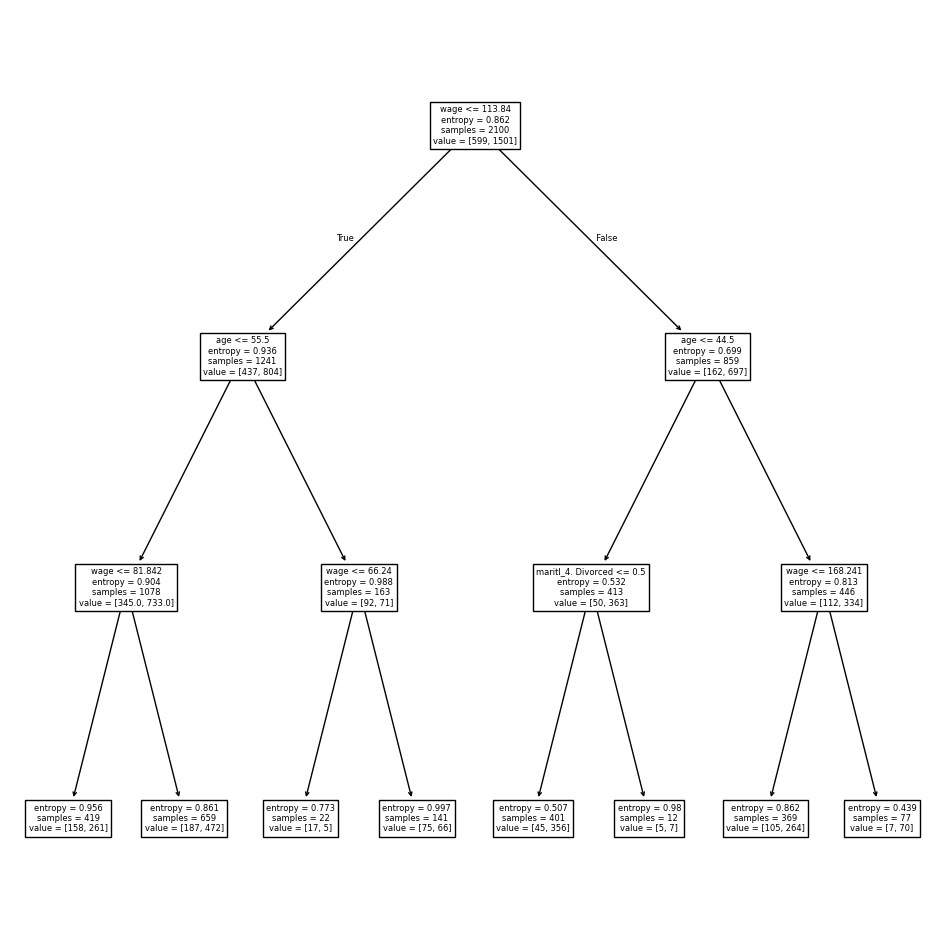

In [61]:
wage_tree = DTC(criterion='entropy', max_depth = 3, random_state = 301).fit(X_train, y_train)
ax = subplots(figsize=(12,12))[1]
plot_tree(wage_tree, feature_names = X_train.columns, ax = ax)
plt.show()

# Bagging

The **bagging** idea employs a *random forest* with all of the explanatory variables

In [63]:
# one-hot encoding (converting string format to something more numeric)
cat_vars = ['maritl', 'race', 'education', 'region', 'jobclass', 'health', 'health_ins']
wage_df = pd.get_dummies(wage_raw, columns = cat_vars)
wage_df.columns

X = wage_df.drop(['health_1. <=Good', 'health_2. >=Very Good', 'logwage'], axis = 1)
y = wage_df['health_2. >=Very Good']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 301)

bag_wage = RF(max_features = X_train.shape[1], #i.e. use all of the predictor variables
                random_state = 301)
bag_wage.fit(X_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,22
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [64]:
feature_imp = pd.DataFrame({'importance':bag_wage.feature_importances_},
                           index = X_train.columns)
feature_imp.sort_values(by='importance', ascending=False)

,importance
wage,0.313278
age,0.256978
year,0.129742
education_2. HS Grad,0.028472
education_3. Some College,0.026333
jobclass_1. Industrial,0.021980
jobclass_2. Information,0.021650
maritl_2. Married,0.021380
education_4. College Grad,0.020351
race_1. White,0.019334


# Regression Trees

* response variable: `logwage`
* explanatory varibles: all except `wage`


In [65]:
# one-hot encoding (converting string format to something more numeric)
cat_vars = ['maritl', 'race', 'education', 'region', 'jobclass', 'health', 'health_ins']
wage_df = pd.get_dummies(wage_raw, columns = cat_vars)
wage_df.columns

X = wage_df.drop(['logwage', 'wage'], axis = 1)
y = wage_df['logwage']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 301)

In [66]:
boost_wage = GBR(n_estimators = 500,
                   learning_rate = 0.1,
                   max_depth = 4,
                   random_state = 301)
boost_wage.fit(X_train, y_train)
y_pred = boost_wage.predict(X_test)
print("MSE:", np.mean((y_test - y_pred)**2))

MSE: 0.09489704861344142


In [67]:
feature_imp = pd.DataFrame({'importance':boost_wage.feature_importances_},
                           index = X_train.columns)
feature_imp.sort_values(by='importance', ascending=False)

,importance
age,0.226868
education_5. Advanced Degree,0.126934
health_ins_1. Yes,0.113701
year,0.093184
health_ins_2. No,0.090638
education_4. College Grad,0.070529
maritl_2. Married,0.051163
education_1. < HS Grad,0.036722
education_2. HS Grad,0.034746
health_2. >=Very Good,0.021626
